In [1]:
import numpy as np
import math
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import torch
from PINN import PINN

In [2]:
%load_ext autoreload
%autoreload 2

# 1D examples 
#### Source: https://www.cantorsparadise.com/the-heat-equation-a76d7773a0b5

## 3)  Random heat distribution: this time, the bar, which we will assume to be made of copper with diffusivity 1.11×10⁻⁴m²/s, has a random heat distribution that’s been measured at 10 centimeter intervals according to the following table: (see source)

### NOTE: This time we do not have a closed-form, so we do not have a test dataset. Anyway, we expect a similar picture to the one obtained in the source.

In [3]:
# INITIALIZATION
alpha = 0.0075
num_series_terms = 500
x = np.linspace(0, 1, num = 50)
t = np.linspace(0, 60, num = 50)
u = np.zeros((t.shape[0], x.shape[0]))

N_boundary: 1000, N_collocation: 1000


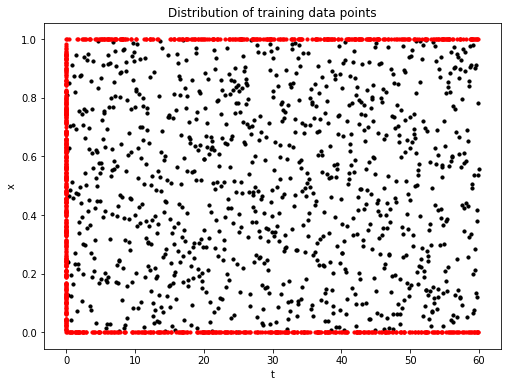

In [4]:
# SEE TRAINING DATA POINTS DISTRIBUTION

# Load datasets and problem data (diffusivity and dimension)
PATH = "./random_heat_dataset"
checkpoint = torch.load(PATH)
x_train = checkpoint['x_train']
y_train = checkpoint['y_train']
input_size = checkpoint['input_size']
alpha = checkpoint['alpha']
N_boundary = checkpoint['N_boundary']
N_collocation = checkpoint['N_collocation']

# Amount of boundary, collocation points
print(f"N_boundary: {N_boundary}, N_collocation: {N_collocation}") #", N_test: {N_test}")

# Plotting the point distribution in (t,x) to observe the distribution of the data generated
# Boundary points in red, collocation points in black
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1.scatter(x_train[N_boundary:,0].detach().numpy(), x_train[N_boundary:,1].detach().numpy(), color = 'black',marker= 'o', s=10)
ax1.scatter(x_train[:N_boundary,0].detach().numpy(), x_train[:N_boundary,1].detach().numpy(), color = 'red',marker= 'o', s=10)
ax1.set_title('Distribution of training data points')
ax1.set_xlabel('t')
ax1.set_ylabel('x')

plt.show()

In [5]:
# SEE MODEL PREDICTION

# INITIAL MODEL (NO TRAINING, ONLY INITIALIZED)
# Load model
PATH = "initial_model"
checkpoint = torch.load(PATH)
model_dict = checkpoint['model_dict']
hidden_sizes = checkpoint['hidden_sizes']
output_size = checkpoint['output_size']

model1 = PINN(h_sizes=hidden_sizes, out_size=output_size)
model1.load_state_dict(model_dict)
model1.eval()

# Evaluate model in the grid
u_model1 = np.zeros((t.shape[0], x.shape[0]))
for i, x_i in enumerate(x):
    for j, t_j in enumerate(t):
        u_model1[j,i] = model1(torch.tensor(np.array([t_j, x_i]).astype(np.float32)))

/Users/Manel/.virtualenvs/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


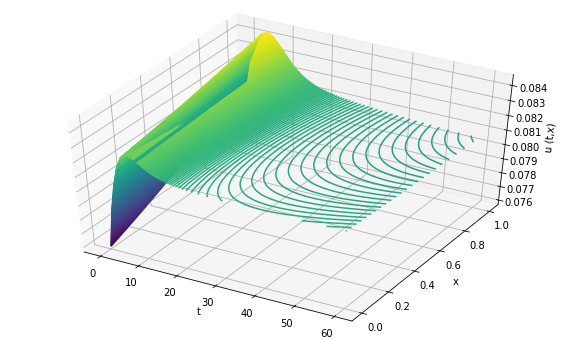

In [6]:
# 3D Plotting the solution from initial model
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
T, X = np.meshgrid(t, x)
ax.contour3D(T, X, u_model1.T, 400, cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u (t,x)');
ax.view_init(45, -60)

# TERRIBLE!

In [7]:
# AFTER TRAINING
# Load model
PATH = "final_model1" 
checkpoint = torch.load(PATH)
model_dict = checkpoint['model_dict']
hidden_sizes = checkpoint['hidden_sizes']
output_size = checkpoint['output_size']

model2 = PINN(h_sizes=hidden_sizes, out_size=output_size)
model2.load_state_dict(model_dict)
model2.eval()

# Evaluate model in the grid
u_model2 = np.zeros((t.shape[0], x.shape[0]))
for i, x_i in enumerate(x):
    for j, t_j in enumerate(t):
        u_model2[j,i] = model2(torch.tensor(np.array([t_j, x_i]).astype(np.float32)))

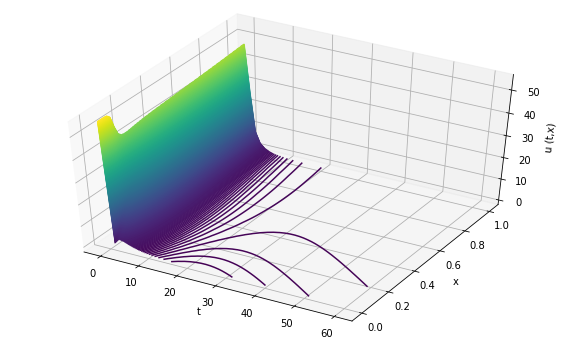

In [8]:
# 3D Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
T, X = np.meshgrid(t, x)
ax.contour3D(T, X, u_model2.T, 400, cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u (t,x)');
ax.view_init(45, -60)

# Result with NN of 7 hidden layers, 20 neurons each, during 100 epochs. Already learning one of the discontinuities 
# in initial conditions. More training (and eventually more hidden layers) required!